In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

<IPython.core.display.Javascript object>

In [63]:
np.random.seed(1000)
%matplotlib inline
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [ ]:
# Given a stock, remove data of data of all non-trading day
def removeNonTradingDays(df):
    return df[df.index.dayofweek < 5]

# Given a list of stocks, find the common interval (latestStart, earliestEnd) for all the stocks
def commonInterval(tickers):
    latestStart = None
    earliestEnd = None
    for data in tickers:
        if latestStart == None or data.index[0] > latestStart:
            latestStart = data.index[0]
        if earliestEnd == None or data.index[-1] < earliestEnd:
            earliestEnd = data.index[-1]
    return (latestStart, earliestEnd)

In [66]:
# Load these stocks
stockNames = ["VUSA", "A35", "S59", "VUSD", "BAB", "IWDA", "Z74", "ES3", "VWRD", "BTC"]
stocks = list(
    map(
        lambda x: removeNonTradingDays(
            pd.read_csv(f"data/{x}.csv", index_col="Date", parse_dates=True)
        ),
        stockNames,
    )
)

<IPython.core.display.Javascript object>

In [34]:
# Find common interval of all stocks and trim them to it
(start, end) = commonInterval(stocks)
trimmedStocksClosingPrices = list(map(lambda x: x[start:end].Close, stocks))

# Fill in NA and normalise closing prices
stocksClosingPrices = pd.concat(trimmedStocksClosingPrices, axis=1, keys=stockNames)
stocksClosingPricesForwardFilled = stocksClosingPrices.fillna(method="ffill")
normalisedClosingPrice = (
    stocksClosingPricesForwardFilled / stocksClosingPricesForwardFilled.iloc[0]
)

<IPython.core.display.Javascript object>

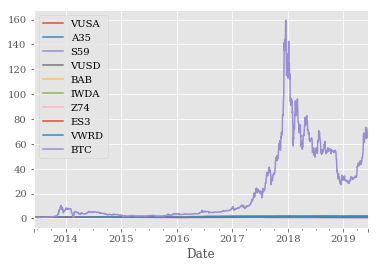

<IPython.core.display.Javascript object>

In [35]:
normalisedClosingPrice.plot()
plt.show()

In [67]:
# Calculate returns of individual assets based on trading days
returns = np.log(normalisedClosingPrice / normalisedClosingPrice.shift(1))
returns.mean() * 252

VUSA    0.116555
A35    -0.003435
S59    -0.111506
VUSD    0.123656
BAB     0.006382
IWDA    0.112410
Z74    -0.016373
ES3    -0.000294
VWRD    0.085848
BTC     0.688380
dtype: float64

<IPython.core.display.Javascript object>

In [69]:
# Calculate covariance of each asset to another based on trading days
retCov = returns.cov() * 252
retCov

,VUSA,A35,S59,VUSD,BAB,IWDA,Z74,ES3,VWRD,BTC
VUSA,0.022677,-0.000161,0.001938,0.017113,-0.001397,0.015510,0.004836,0.005984,0.015387,0.005472
A35,-0.000161,0.008798,-0.000044,-0.000117,0.000284,-0.000010,0.000010,-0.000351,0.000095,0.002690
S59,0.001938,-0.000044,0.024061,0.001086,-0.000247,0.001383,0.004336,0.004458,0.001403,-0.004405
VUSD,0.017113,-0.000117,0.001086,0.019929,-0.000829,0.017988,0.004177,0.004434,0.017860,0.003496
BAB,-0.001397,0.000284,-0.000247,-0.000829,0.003838,-0.000924,-0.000146,-0.000403,-0.000883,-0.000057
IWDA,0.015510,-0.000010,0.001383,0.017988,-0.000924,0.017311,0.004709,0.005054,0.017231,0.002094
Z74,0.004836,0.000010,0.004336,0.004177,-0.000146,0.004709,0.025644,0.010123,0.004937,-0.000259
ES3,0.005984,-0.000351,0.004458,0.004434,-0.000403,0.005054,0.010123,0.013562,0.005285,-0.003810
VWRD,0.015387,0.000095,0.001403,0.017860,-0.000883,0.017231,0.004937,0.005285,0.017495,0.002736
BTC,0.005472,0.002690,-0.004405,0.003496,-0.000057,0.002094,-0.000259,-0.003810,0.002736,1.214764


<IPython.core.display.Javascript object>

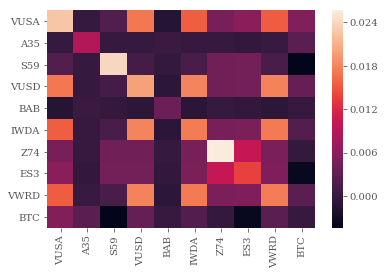

<IPython.core.display.Javascript object>

In [54]:
# Specifically removing covariance of BTC-BTC to prevent it from skewing the scale
retCov["BTC"]["BTC"] = 0
sns.heatmap(retCov)
plt.show()

In [55]:
def randomWeight(length):
    w = np.random.random(length)
    w /= np.sum(w)
    return w


def expectedPortfolioRet(returns, weight):
    return np.sum(returns.mean() * weight) * 252


def expectedPortfolioVar(returns, weight):
    return np.dot(weight, np.dot(returns.cov() * 252, weight))


def expectedSharpeRatio(returns, weight, rf=0):
    return (expectedPortfolioRet(returns, weight) - rf) / expectedPortfolioVar(
        returns, weight
    )

<IPython.core.display.Javascript object>

In [85]:
# Find performance of current portfolio to be used as benchmark
currentWeight = [
    0.08992020522,
    0.2744348384,
    0.03070927321,
    0.01896821775,
    0.06166520726,
    0.06204753154,
    0.02053451402,
    0.3393806347,
    0.102339578,
    0,
]

print(f"Sharpe Ratio: {expectedSharpeRatio(returns, currentWeight, 0.02)}")
print(f"Returns: {expectedPortfolioRet(returns, currentWeight)}")
print(f"Volatility: {expectedPortfolioVar(returns, currentWeight)}")

Sharpe Ratio: 0.8765527874357544
Returns: 0.024177333251220037
Volatility: 0.004765637975369746


<IPython.core.display.Javascript object>

In [74]:
noSimulations = 100000
rf = 0.02
simWeights = []
simRets = []
simVols = []
simSharpes = []

for i in range(noSimulations):
    weights = randomWeight(10)
    simWeights.append(weights)
    ret = expectedPortfolioRet(returns, weights)
    var = expectedPortfolioVar(returns, weights)
    simRets.append(ret)
    simVols.append(var)
    simSharpes.append(expectedSharpeRatio(returns, weights, rf))

<IPython.core.display.Javascript object>

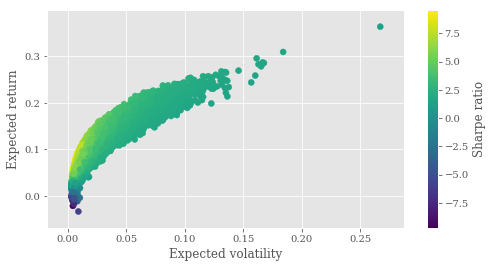

<IPython.core.display.Javascript object>

In [75]:
plt.figure(figsize=(8, 4))
plt.scatter(simVols, simRets, c=simSharpes, marker="o")
plt.grid(True)
plt.xlabel("Expected volatility")
plt.ylabel("Expected return")
plt.colorbar(label="Sharpe ratio")
plt.show()

In [76]:
# Get top 10 with lowest volatility
sortedIndices = np.argsort(simVols)[:10]

results = []
for x in sortedIndices:
    results.append(
        np.insert(simWeights[x] * 100000, 0, [simSharpes[x], simRets[x], simVols[x]])
    )
pd.DataFrame(results, columns=["SharpeRatio", "Returns", "Volatility"] + stockNames)

,SharpeRatio,Returns,Volatility,VUSA,A35,S59,VUSD,BAB,IWDA,Z74,ES3,VWRD,BTC
0,-7.619681,-0.001613,0.002836,771.460029,28397.778807,13208.233954,2052.812723,23063.480157,6015.023898,8989.792776,15509.829544,1621.921718,369.666391
1,2.145913,0.026105,0.002845,3923.829112,28163.550215,6285.344691,3174.327966,27512.240839,6408.242318,7023.362962,6979.081284,9077.185119,1452.835493
2,3.098376,0.028907,0.002875,13793.100725,20133.455165,7216.360803,2961.247413,33816.637087,1330.858082,3469.125993,13784.174373,1526.602381,1968.437978
3,-0.327470,0.018982,0.003110,6943.261180,25335.730879,7826.937417,3105.497689,23275.718499,3290.728275,4153.400976,23471.835059,940.261534,1656.628492
4,1.211124,0.023789,0.003129,1108.155850,29397.069082,8613.155884,1237.263077,21129.947862,26763.736178,4530.081423,7083.549722,5.437534,131.603387
5,0.767520,0.022408,0.003137,13155.798320,18835.552707,1756.126326,851.691031,29158.459295,863.710336,387.375437,28430.322381,6509.673336,51.290833
6,-1.858491,0.014123,0.003162,4712.716185,23566.754975,10545.417975,6709.362603,21399.238359,3224.729877,10723.154972,14855.282705,3259.053164,1004.289185
7,-6.036110,0.000736,0.003192,3497.930394,12239.184414,15774.352533,5270.218556,31436.325037,55.927226,14847.032599,6940.369114,9938.405262,0.254864
8,0.360412,0.021164,0.003228,3371.855776,20109.425063,10747.729577,11634.970301,24635.575993,3996.928419,5859.832530,8673.494410,10800.324091,169.863840
9,2.142600,0.026940,0.003239,4522.724577,24592.725148,7685.140835,14939.388521,24135.877115,4121.377200,13270.069364,4076.403740,1604.013243,1052.280258


<IPython.core.display.Javascript object>

In [77]:
# Get top 10 portfolio with highest sharpe
sortedIndices = np.argsort(simSharpes)[-10:]

results = []
for x in sortedIndices:
    results.append(
        np.insert(simWeights[x] * 100000, 0, [simSharpes[x], simRets[x], simVols[x]])
    )
pd.DataFrame(results, columns=["SharpeRatio", "Returns", "Volatility"] + stockNames)

,SharpeRatio,Returns,Volatility,VUSA,A35,S59,VUSD,BAB,IWDA,Z74,ES3,VWRD,BTC
0,8.702161,0.084005,0.007355,19411.604744,11999.027338,1415.873650,3749.786590,23804.785431,22652.264288,4350.576832,5911.840450,2268.766600,4435.474076
1,8.709481,0.071465,0.005909,1805.613084,19045.615498,2726.574941,11708.585321,26341.191692,21669.197942,3145.870709,4264.256207,5129.508046,4163.586560
2,8.742592,0.079934,0.006855,15015.262975,15734.565246,3435.294558,8756.671894,21920.742833,21106.304478,604.537922,4922.286129,4576.849764,3927.484200
3,8.797854,0.094870,0.008510,19223.484061,9776.211141,726.603606,14163.621293,23982.992421,19164.539263,1888.743163,5937.738643,333.013462,4803.052948
4,8.809849,0.057327,0.004237,23479.370962,19130.970055,677.972538,1792.247749,31331.650517,11252.666850,2113.669327,2874.768871,5926.561476,1420.121656
5,8.850093,0.075194,0.006237,22011.516529,18750.424940,1057.588908,9193.151750,20669.605730,12364.858375,1001.818279,11048.753004,313.693601,3588.588885
6,8.871101,0.077711,0.006506,13176.536056,25096.587263,1397.918285,23163.447635,16842.521666,9487.288716,9.722625,3073.149454,4807.446834,2945.381465
7,8.966423,0.073437,0.005960,15430.036717,19479.225190,325.864224,5325.437803,20852.134893,19970.418718,3305.010842,5492.434378,6790.983299,3028.453936
8,8.986578,0.060371,0.004492,11090.827965,20378.438216,352.889076,4570.103964,26321.197778,19536.878332,5040.458564,5432.256383,4980.073452,2296.876271
9,9.525976,0.080642,0.006366,17899.606713,14606.543948,624.082725,20692.840975,28909.341075,5529.700368,2576.045165,3078.659425,2342.908832,3740.270775


<IPython.core.display.Javascript object>

## Future Improvements

- Simulation of 100k scenarios is too slow, consider using genetics algorithm to find minima
- Account for foreign currency conversion rates
- K-fold cross validation to ensure the portfolio works for all market condition
- Backtest portfolio in different market conditions
- Add regular rebalancing into backtest
- Simulated returns of portfolio
- Difference in trading day alter covariance (BTC)